In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 4 — Supervised Learning Basics
## Lesson 11: Robust Regression (Huber, RANSAC Concepts and Use Cases)



Robust regression is the part of supervised learning that answers a pragmatic question:

> **How do we fit a useful regression model when real-world data contain outliers, mislabeled records, rare events, sensor glitches, or distribution tails that violate “nice” assumptions?**

In earlier lessons, we used ordinary least squares (OLS) linear regression and evaluated models using metrics such as MAE, MSE, and RMSE. OLS is *optimal* under a specific probabilistic model: i.i.d. Gaussian noise with constant variance and no influential outliers. But in practice, even a small fraction of corrupted observations can distort an OLS fit dramatically—sometimes changing the sign of coefficients or producing nonsensical predictions.

This lesson covers two widely used robust regression ideas:

1. **Huber regression** (an **M-estimator**): uses a loss function that is quadratic near zero residuals and linear for large residuals, reducing the influence of outliers while retaining high efficiency under near-Gaussian noise.
2. **RANSAC** (Random Sample Consensus): a robust **inlier/outlier** strategy that repeatedly fits a model on small random subsets and keeps the fit that is supported by the largest set of inliers.

We will implement and compare these methods on multiple datasets from your repository. We will also build practical intuition about:

- When robust regression is the right tool (and when it is not).
- How Huber’s parameter $\epsilon$ controls the “turning point” between quadratic and linear penalty.
- How RANSAC’s residual threshold, minimum sample size, and stopping criteria shape its behavior.
- How to evaluate robustness under adversarial outliers (data contamination experiments).
- How robust methods relate to heavy-tailed distributions and median-based statistics.

**Important notebook conventions**

- Mathematical expressions in Markdown use `$...$` and `$$...$$`.
- Dataset paths follow the repository structure, e.g. `"../../../Datasets/Regression/salaries.csv"`.
- Plots and code comments remain in English (also in the Persian notebook).



### Learning objectives

By the end of this lesson, you should be able to:

- Explain why OLS is sensitive to outliers using the geometry of least squares and influence functions.
- Write down the Huber loss and interpret its behavior for small vs large residuals.
- Fit and evaluate `HuberRegressor` and `RANSACRegressor` in scikit-learn.
- Choose robust hyperparameters using residual scale estimates (MAD-based thresholds).
- Perform a controlled “contamination test” to compare robustness across models.
- Apply robust regression to both **simple** and **mixed-feature** tabular datasets using pipelines.



---
## 1. Why ordinary least squares is fragile

Consider a regression dataset $\{(x_i, y_i)\}_{i=1}^n$ and a model $f(x;\beta)$ (e.g., linear $\beta^\top x$). OLS fits parameters by minimizing:

$$
\hat{\beta}_{\text{OLS}} = \arg\min_{\beta} \sum_{i=1}^n r_i(\beta)^2
\quad\text{where}\quad r_i(\beta)=y_i-f(x_i;\beta).
$$

OLS *squares* the residual. This has a useful property: it strongly penalizes moderate errors and yields a closed-form solution for linear models. But it also has a dangerous side-effect: **a single large residual can dominate the objective**.

### 1.1 Influence intuition

If an observation has a very large residual $|r_i|$, its contribution to the objective is $r_i^2$, which grows quadratically. The gradient contribution of that point is proportional to $2 r_i \cdot \partial r_i/\partial\beta$, meaning the optimization “listens” very strongly to extreme residuals.

A related concept is the **influence function**, which—informally—measures how much a tiny contamination at a point changes the estimator. OLS has *unbounded* influence: extreme points can move the fit arbitrarily.

### 1.2 Outliers in $y$ vs outliers in $x$

Not all outliers are equal:

- **Vertical outliers**: unusual $y$ values at typical $x$ locations (often label noise, measurement error).
- **Leverage points**: unusual $x$ values (rare feature combinations). These can be particularly harmful because they can “pull” the regression line/plane.
- **Bad leverage points**: unusual $x$ values *and* inconsistent $y$ values. These are worst-case for OLS.

Huber regression mainly guards against **large residuals** (often vertical outliers). RANSAC is better at handling **gross outliers** including bad leverage points, because it explicitly tries to identify an inlier set that supports a consistent model.

### 1.3 Robustness as distributional thinking

OLS corresponds to a Gaussian noise model. Robust regression can be viewed as choosing a different noise model, often with heavier tails (e.g., Laplace-like behavior). In robust statistics, we often care about:

- **Breakdown point**: the fraction of contamination the estimator can tolerate before failing completely.
- **Efficiency**: performance under ideal conditions (e.g., pure Gaussian noise).
- **Computational practicality**: can we fit it reliably and quickly?

Huber has high efficiency and moderate robustness; RANSAC can tolerate a larger fraction of outliers but may be unstable if the inlier structure is weak or if hyperparameters are poorly chosen.



---
## 2. Huber regression (M-estimation)

### 2.1 Huber loss

For a residual $r$, the Huber loss with parameter $\epsilon>0$ is:

$$
\rho_\epsilon(r)=
\begin{cases}
\tfrac{1}{2} r^2 & \text{if } |r|\le \epsilon, \\
\epsilon\left(|r| - \tfrac{1}{2}\epsilon\right) & \text{if } |r|>\epsilon.
\end{cases}
$$

Key behavior:

- For small residuals, it behaves like squared loss (smooth, efficient for Gaussian noise).
- For large residuals, it grows linearly like absolute loss (limits the effect of extreme points).

The derivative (the “psi-function”) is:

$$
\psi_\epsilon(r)=\rho_\epsilon'(r)=
\begin{cases}
r & |r|\le \epsilon, \\
\epsilon\,\mathrm{sign}(r) & |r|>\epsilon.
\end{cases}
$$

So large residuals contribute a **bounded** gradient magnitude (capped at $\epsilon$), which is the essential robustness property.

### 2.2 Interpretation of $\epsilon$

- Larger $\epsilon$ makes Huber closer to OLS (less robust, more efficient under Gaussian noise).
- Smaller $\epsilon$ makes Huber closer to absolute loss (more robust, but can be less efficient and sometimes harder to optimize).

In scikit-learn’s `HuberRegressor`, `epsilon` is the threshold in units of residual scale. A common practical approach is to standardize features and ensure the target is on a reasonable scale (or use a log transform) before choosing `epsilon`.

### 2.3 Regularization

`HuberRegressor` also supports L2 regularization via `alpha` (ridge-style). With robust loss, regularization becomes even more important in high-dimensional or collinear settings.

A stylized objective is:

$$
\min_{\beta} \sum_{i=1}^n \rho_\epsilon\big(y_i-\beta^\top x_i\big) + \alpha \|\beta\|_2^2.
$$

### 2.4 When Huber helps

Huber regression is often a good default when:

- You suspect a small-to-moderate fraction of outliers in the target.
- You want a single convex objective that can be optimized reliably.
- You want similar behavior to least squares but with reduced sensitivity.



---
## 3. RANSAC (Random Sample Consensus)

RANSAC is built around an explicit **inlier model**: most data points follow a model with small noise; the rest are outliers that should be ignored.

### 3.1 Algorithm sketch

Given a base estimator (often linear regression), RANSAC repeats:

1. Randomly sample a minimal subset of points (size `min_samples`).
2. Fit the base model on this subset.
3. Compute residuals on all points.
4. Classify points as **inliers** if $|r_i| \le t$ (threshold `residual_threshold`).
5. Score the model by the number of inliers (or a robust score).
6. Keep the best model and optionally refit on all inliers.

It succeeds when: an iteration samples an all-inlier subset. If the inlier fraction is $w$, and the minimal subset size is $m$, then the probability a random subset is all inliers is $w^m$. The number of iterations $N$ needed to get success with probability $p$ is:

$$
N \ge \frac{\log(1-p)}{\log(1-w^m)}.
$$

This explains why RANSAC can become expensive when $w$ is small, or when the model requires many points to fit (large $m$).

### 3.2 Hyperparameters that matter

- `min_samples`: minimal sample size per trial. For linear regression with $d$ features, a typical lower bound is $d+1$ (but scikit-learn can handle larger).
- `residual_threshold`: inlier cutoff $t$. Too small → too few inliers; too large → outliers become inliers.
- `max_trials`: iteration budget (related to the formula above).
- `stop_probability`: desired success probability $p$.
- `loss`: how residuals are computed (`absolute_error`, `squared_error`, ...).

### 3.3 Choosing the residual threshold with MAD

A robust way to estimate residual scale uses the **median absolute deviation (MAD)**:

$$
\mathrm{MAD}(r)=\mathrm{median}(|r_i-\mathrm{median}(r)|).
$$

For approximately Gaussian residuals, a consistent scale estimate is:

$$
\hat{\sigma} \approx 1.4826\,\mathrm{MAD}(r).
$$

A common heuristic for RANSAC is:

$$
t = k\hat{\sigma}, \quad k \in [2, 3, 4].
$$

We will demonstrate this in code and show how the choice affects inlier selection.

### 3.4 When RANSAC helps

RANSAC shines when:

- Outliers are gross and you can reasonably assume a dominant inlier model.
- You expect bad leverage points.
- The relationship is “mostly linear” (or matches your base estimator) for inliers.

However, RANSAC can fail when:

- Inliers do not dominate, or the data contain multiple competing structures.
- Noise is heavy-tailed without clear separation between inliers and outliers.
- Hyperparameters are poorly chosen, especially the residual threshold.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# RANSAC changed parameter names across sklearn versions (base_estimator -> estimator).
from sklearn.linear_model import RANSACRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def regression_report(y_true, y_pred, prefix=""):
    return {
        f"{prefix}MAE": float(mean_absolute_error(y_true, y_pred)),
        f"{prefix}RMSE": rmse(y_true, y_pred),
        f"{prefix}R2": float(r2_score(y_true, y_pred)),
    }

def print_report(name, y_true, y_pred):
    rep = regression_report(y_true, y_pred)
    print(f"{name}: MAE={rep['MAE']:.4f} | RMSE={rep['RMSE']:.4f} | R2={rep['R2']:.4f}")

def robust_sigma_mad(residuals):
    r = np.asarray(residuals)
    med = np.median(r)
    mad = np.median(np.abs(r - med))
    return 1.4826 * mad


---
## 4. Visual intuition: squared vs absolute vs Huber loss

Before applying robust methods to real datasets, it helps to visualize how different loss functions respond to residual magnitude.

- **Squared loss** $\tfrac{1}{2}r^2$ keeps growing quickly as $|r|$ increases.
- **Absolute loss** $|r|$ grows linearly, so extreme residuals do not dominate.
- **Huber loss** blends both: quadratic near zero, linear in the tails.

In many datasets, most points have small residuals and a few points have very large residuals. Huber aims to treat the “bulk” like OLS while preventing the tails from taking over.


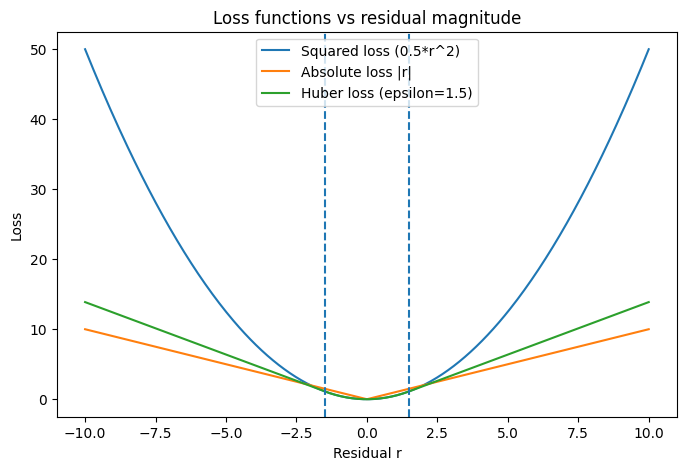

In [3]:
rs = np.linspace(-10, 10, 400)
eps = 1.5

sq = 0.5 * rs**2
abs_loss = np.abs(rs)
huber = np.where(np.abs(rs) <= eps, 0.5 * rs**2, eps * (np.abs(rs) - 0.5 * eps))

plt.figure(figsize=(8, 5))
plt.plot(rs, sq, label="Squared loss (0.5*r^2)")
plt.plot(rs, abs_loss, label="Absolute loss |r|")
plt.plot(rs, huber, label=f"Huber loss (epsilon={eps})")
plt.axvline(eps, linestyle="--")
plt.axvline(-eps, linestyle="--")
plt.xlabel("Residual r")
plt.ylabel("Loss")
plt.title("Loss functions vs residual magnitude")
plt.legend()
plt.show()


---
## 5. Controlled experiment: one-dimensional line with outliers

A clean way to compare robustness is to create a simple synthetic regression problem where the true relationship is known, then inject outliers. We will fit:

- OLS linear regression
- Huber regression
- RANSAC with a linear base estimator

and compare both visually and numerically.

This kind of “contamination test” mimics real-world data collection issues: a sensor occasionally saturates, a few records are mislabeled, or a data pipeline introduces rare but extreme errors.


OLS: MAE=2.5815 | RMSE=6.2677 | R2=0.6808
Huber: MAE=2.3939 | RMSE=6.3379 | R2=0.6736
RANSAC: MAE=2.4346 | RMSE=6.3694 | R2=0.6704


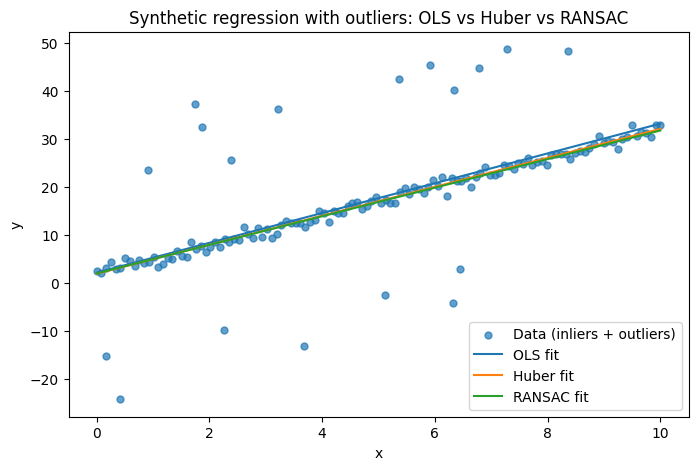

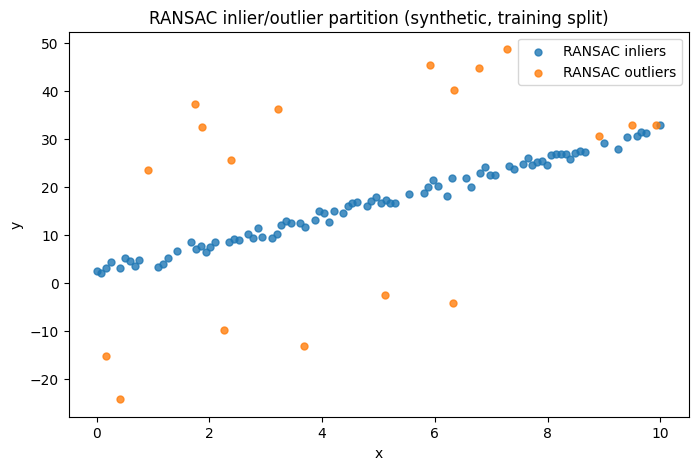

In [4]:
# Generate a clean linear relationship
n_inliers = 120
x = np.linspace(0, 10, n_inliers)
y = 3.0 * x + 2.0 + np.random.normal(scale=1.0, size=n_inliers)

# Inject outliers
n_outliers = 18
x_out = np.random.uniform(0, 10, size=n_outliers)
y_out = 3.0 * x_out + 2.0 + np.random.normal(scale=1.0, size=n_outliers)
y_out += np.random.choice([-1, 1], size=n_outliers) * np.random.uniform(15, 30, size=n_outliers)  # big vertical shifts

X = np.concatenate([x, x_out]).reshape(-1, 1)
Y = np.concatenate([y, y_out])

# Train/test split (just to report metrics)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=RANDOM_STATE)

ols = LinearRegression()
huber_model = HuberRegressor(epsilon=1.5, alpha=0.0001, max_iter=5000)

# RANSAC: pick parameter name robustly
try:
    ransac = RANSACRegressor(
        estimator=LinearRegression(),
        min_samples=2,
        residual_threshold=3.0,  # in y-units
        max_trials=500,
        random_state=RANDOM_STATE,
    )
except TypeError:
    ransac = RANSACRegressor(
        base_estimator=LinearRegression(),
        min_samples=2,
        residual_threshold=3.0,
        max_trials=500,
        random_state=RANDOM_STATE,
    )

ols.fit(X_train, y_train)
huber_model.fit(X_train, y_train)
ransac.fit(X_train, y_train)

pred_ols = ols.predict(X_test)
pred_huber = huber_model.predict(X_test)
pred_ransac = ransac.predict(X_test)

print_report("OLS", y_test, pred_ols)
print_report("Huber", y_test, pred_huber)
print_report("RANSAC", y_test, pred_ransac)

# Plot fits
xx = np.linspace(0, 10, 200).reshape(-1, 1)
plt.figure(figsize=(8, 5))
plt.scatter(X, Y, s=25, alpha=0.7, label="Data (inliers + outliers)")
plt.plot(xx, ols.predict(xx), label="OLS fit")
plt.plot(xx, huber_model.predict(xx), label="Huber fit")
plt.plot(xx, ransac.predict(xx), label="RANSAC fit")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Synthetic regression with outliers: OLS vs Huber vs RANSAC")
plt.legend()
plt.show()

# Show which points RANSAC considered inliers
# Show which points RANSAC considered inliers.
# Note: ransac.inlier_mask_ is defined for the data used in ransac.fit(...).
# Here, ransac was fit on (X_train, y_train), so we visualize inliers on the training split.
inlier_mask = getattr(ransac, "inlier_mask_", None)
if inlier_mask is not None:
    X_plot = X_train
    y_plot = y_train

    plt.figure(figsize=(8, 5))
    plt.scatter(X_plot[inlier_mask], y_plot[inlier_mask], s=25, alpha=0.8, label="RANSAC inliers")
    plt.scatter(X_plot[~inlier_mask], y_plot[~inlier_mask], s=25, alpha=0.8, label="RANSAC outliers")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("RANSAC inlier/outlier partition (synthetic, training split)")
    plt.legend()
    plt.show()



---
## 6. Dataset 1 (Regression): `salaries.csv` — robust regression with categorical features

We will now apply robust regression to a simple dataset in your repository:

- Path: `"../../../Datasets/Regression/salaries.csv"`
- Columns: `Name, Age, Job, Salary`

This dataset is useful for illustrating **categorical encoding** (Job) and robustness against a few unusual salaries.

### 6.1 Setup and preprocessing

We will build a preprocessing pipeline:

- Numeric: impute missing values (if any), standardize features.
- Categorical: impute, one-hot encode `Job`.

Then we compare models.

### 6.2 Outlier simulation

To stress-test robustness, we will create a contaminated version of the dataset by multiplying the salaries of a small fraction of rows by a large factor. This simulates, for example:

- A currency conversion bug.
- A data entry error (extra zero).
- A pipeline join error that duplicates salary values.

Robust methods should degrade more gracefully than OLS.


In [5]:
path = "../../../Datasets/Regression/salaries.csv"
df = pd.read_csv(path)
df.head()

,Name,Age,Job,Salary
0,Kevin Sanders,24,Software Engineer,7300
1,Lisa Mills,26,High School Teacher,6100
2,Donna Allison,27,Dentist,12700
3,Michael Schmitt,43,Dentist,17500
4,Lisa Shaffer,31,Accountant,7400


In [6]:
# Prepare features/target
target_col = "Salary"
X_df = df.drop(columns=[target_col])
y = df[target_col].astype(float).values

# Basic feature typing
numeric_features = ["Age"]
categorical_features = ["Job"]

# OneHotEncoder: handle sklearn version differences (sparse_output introduced in newer versions)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

# Models wrapped in a pipeline
ols_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

huber_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=5000))
])

# RANSAC pipeline
try:
    ransac_est = RANSACRegressor(
        estimator=LinearRegression(),
        min_samples=0.7,          # fraction of samples (sklearn supports float)
        residual_threshold=None,  # we will set after a quick baseline
        max_trials=1000,
        random_state=RANDOM_STATE,
    )
except TypeError:
    ransac_est = RANSACRegressor(
        base_estimator=LinearRegression(),
        min_samples=0.7,
        residual_threshold=None,
        max_trials=1000,
        random_state=RANDOM_STATE,
    )

ransac_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ransac_est)
])

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3, random_state=RANDOM_STATE)

# Fit baseline OLS to get a residual scale estimate for RANSAC threshold
ols_pipe.fit(X_train, y_train)
resid = y_train - ols_pipe.predict(X_train)
sigma_hat = robust_sigma_mad(resid)
sigma_hat

np.float64(986.1914606619855)

In [7]:
# Set RANSAC threshold as k * robust sigma (units of Salary)
k = 2.5
ransac_pipe.set_params(model__residual_threshold=k * sigma_hat)

# Fit and evaluate
for name, model in [("OLS", ols_pipe), ("Huber", huber_pipe), ("RANSAC", ransac_pipe)]:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print_report(name, y_test, pred)

OLS: MAE=649.4812 | RMSE=791.9680 | R2=0.9647
Huber: MAE=649.0409 | RMSE=791.9849 | R2=0.9647
RANSAC: MAE=649.4812 | RMSE=791.9680 | R2=0.9647


In [8]:
# Contamination test: inject a few extreme salary outliers into the training set
rng = np.random.default_rng(RANDOM_STATE)

X_train_c = X_train.copy()
y_train_c = y_train.copy()

n_contam = max(1, int(0.15 * len(y_train_c)))  # 15% contamination
idx = rng.choice(len(y_train_c), size=n_contam, replace=False)
y_train_c[idx] = y_train_c[idx] * rng.uniform(2.5, 5.0, size=n_contam)

print("Contaminated indices:", idx[:10], "..." if len(idx) > 10 else "")

# Refit on contaminated data and compare
for name, model in [("OLS", ols_pipe), ("Huber", huber_pipe), ("RANSAC", ransac_pipe)]:
    model.fit(X_train_c, y_train_c)
    pred = model.predict(X_test)
    print_report(f"{name} (trained on contaminated data)", y_test, pred)

Contaminated indices: [559  66 228 446  40 557 476  56 459 573] ...
OLS (trained on contaminated data): MAE=5481.2385 | RMSE=5850.6700 | R2=-0.9281
Huber (trained on contaminated data): MAE=684.1028 | RMSE=812.3836 | R2=0.9628
RANSAC (trained on contaminated data): MAE=1721.2800 | RMSE=2057.7400 | R2=0.7615



### 6.3 Visualizing predictions vs actuals

A simple diagnostic is a scatter plot of predicted vs actual salary. Robust methods should remain closer to the diagonal after contamination.


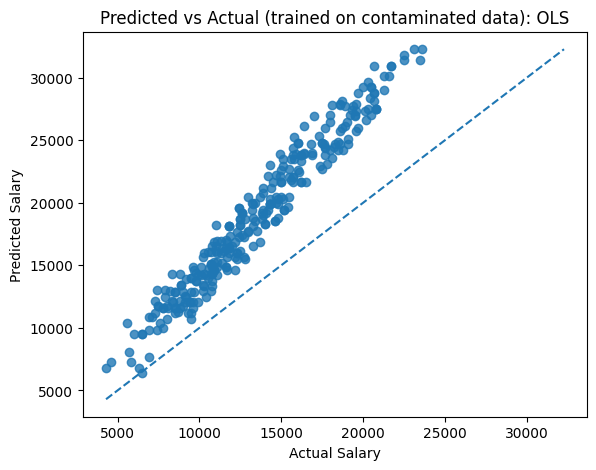

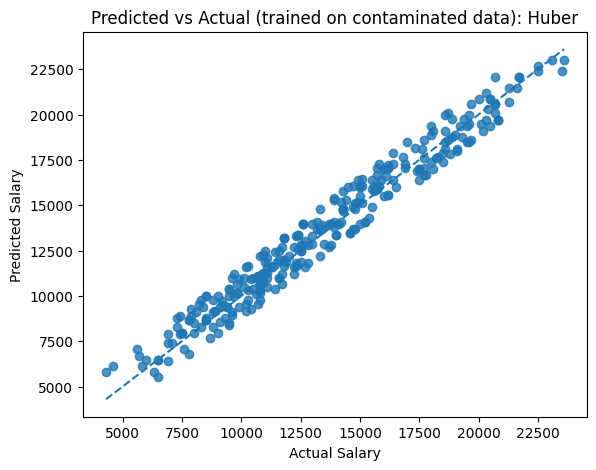

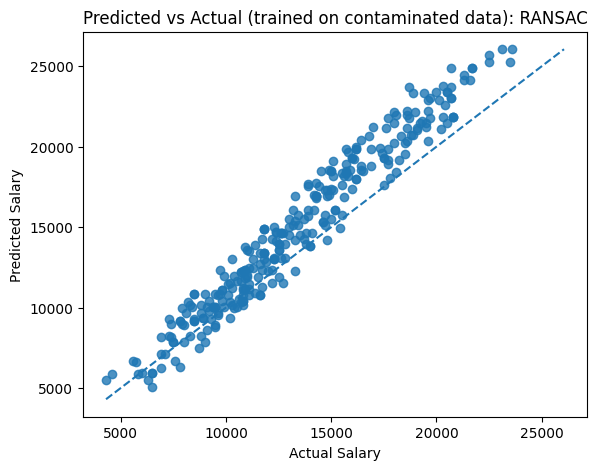

In [9]:
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(6.5, 5))
    plt.scatter(y_true, y_pred, alpha=0.8)
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi], linestyle="--")
    plt.xlabel("Actual Salary")
    plt.ylabel("Predicted Salary")
    plt.title(title)
    plt.show()

# Fit on contaminated data for comparison plots
models = {
    "OLS": ols_pipe,
    "Huber": huber_pipe,
    "RANSAC": ransac_pipe
}

preds = {}
for name, model in models.items():
    model.fit(X_train_c, y_train_c)
    preds[name] = model.predict(X_test)
    plot_pred_vs_actual(y_test, preds[name], title=f"Predicted vs Actual (trained on contaminated data): {name}")


---
## 7. Dataset 2 (Regression): `house-prices.csv` — robustness with mixed features and leverage effects

Next, we use:

- Path: `"../../../Datasets/Regression/house-prices.csv"`
- Target: `Price`
- Mixed features: numeric (`SqFt`, `Bedrooms`, `Bathrooms`, `Offers`) and categorical (`Brick`, `Neighborhood`).

This dataset is helpful to discuss **leverage** and the danger of extreme feature values (e.g., an unusually large house size or a rare neighborhood-category combination). Robust regression does not magically solve leverage problems, but it can reduce the effect of points that create extreme residuals.

We will:

1. Fit the same three models in a pipeline.
2. Inject outliers in **both** the target (`Price`) and one feature (`SqFt`) to demonstrate different failure modes.
3. Use MAD-based thresholds for RANSAC again.


In [10]:
path = "../../../Datasets/Regression/house-prices.csv"
house = pd.read_csv(path)
house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [11]:
target = "Price"
Xh = house.drop(columns=[target])
yh = house[target].astype(float).values

num_cols = ["SqFt", "Bedrooms", "Bathrooms", "Offers"]
cat_cols = ["Brick", "Neighborhood"]

try:
    ohe2 = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe2 = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess2 = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", ohe2)]), cat_cols),
    ],
    remainder="drop"
)

ols2 = Pipeline([("preprocess", preprocess2), ("model", LinearRegression())])
huber2 = Pipeline([("preprocess", preprocess2), ("model", HuberRegressor(epsilon=1.35, alpha=0.0005, max_iter=5000))])

try:
    ransac2_est = RANSACRegressor(
        estimator=LinearRegression(),
        min_samples=0.6,
        residual_threshold=None,
        max_trials=2000,
        random_state=RANDOM_STATE,
    )
except TypeError:
    ransac2_est = RANSACRegressor(
        base_estimator=LinearRegression(),
        min_samples=0.6,
        residual_threshold=None,
        max_trials=2000,
        random_state=RANDOM_STATE,
    )

ransac2 = Pipeline([("preprocess", preprocess2), ("model", ransac2_est)])

Xh_train, Xh_test, yh_train, yh_test = train_test_split(Xh, yh, test_size=0.25, random_state=RANDOM_STATE)

# Baseline residual scale to set RANSAC threshold
ols2.fit(Xh_train, yh_train)
resid2 = yh_train - ols2.predict(Xh_train)
sigma2 = robust_sigma_mad(resid2)
ransac2.set_params(model__residual_threshold=2.5 * sigma2)

# Clean training
print("Clean training:")
for name, model in [("OLS", ols2), ("Huber", huber2), ("RANSAC", ransac2)]:
    model.fit(Xh_train, yh_train)
    pred = model.predict(Xh_test)
    print_report(name, yh_test, pred)

Clean training:
OLS: MAE=8371.6640 | RMSE=10301.3489 | R2=0.8269
Huber: MAE=8133.9859 | RMSE=10104.4945 | R2=0.8334
RANSAC: MAE=8318.5088 | RMSE=10325.4482 | R2=0.8261


In [12]:
# Contaminate: price outliers + leverage in SqFt
rng = np.random.default_rng(RANDOM_STATE)

Xh_train_c = Xh_train.copy()
yh_train_c = yh_train.copy()

n_contam = max(1, int(0.12 * len(yh_train_c)))

idx_price = rng.choice(len(yh_train_c), size=n_contam, replace=False)
yh_train_c[idx_price] = yh_train_c[idx_price] * rng.uniform(2.0, 4.0, size=n_contam)

# Leverage: make some houses unrealistically large (SqFt)
Xh_train_c["SqFt"] = Xh_train_c["SqFt"].astype(float)  # avoid dtype warnings when multiplying by floats
idx_sqft = rng.choice(len(yh_train_c), size=max(1, int(0.08 * len(yh_train_c))), replace=False)
Xh_train_c.loc[Xh_train_c.index[idx_sqft], "SqFt"] = Xh_train_c.loc[Xh_train_c.index[idx_sqft], "SqFt"] * rng.uniform(2.5, 4.5, size=len(idx_sqft))

print("Contamination summary:")
print("  Price outliers:", len(idx_price))
print("  SqFt leverage points:", len(idx_sqft))

print("\nTrained on contaminated data:")
for name, model in [("OLS", ols2), ("Huber", huber2), ("RANSAC", ransac2)]:
    model.fit(Xh_train_c, yh_train_c)
    pred = model.predict(Xh_test)
    print_report(f"{name} (contaminated train)", yh_test, pred)

Contamination summary:
  Price outliers: 11
  SqFt leverage points: 7

Trained on contaminated data:
OLS (contaminated train): MAE=33787.7345 | RMSE=38617.2151 | R2=-1.4327
Huber (contaminated train): MAE=9406.1638 | RMSE=11905.1155 | R2=0.7688
RANSAC (contaminated train): MAE=8540.3427 | RMSE=10400.5905 | R2=0.8235



### 7.1 Residual diagnostics

Robust regression is not only about metrics; it is also about **residual structure**. Here we plot residuals vs predictions to see whether a model is being “pulled” by a few extreme points.

For robust methods, you often see:

- A tighter residual band for the inlier mass.
- Fewer extreme residuals.
- Less heteroskedastic blow-up caused by influential points.

(These plots are quick diagnostics—not proofs.)


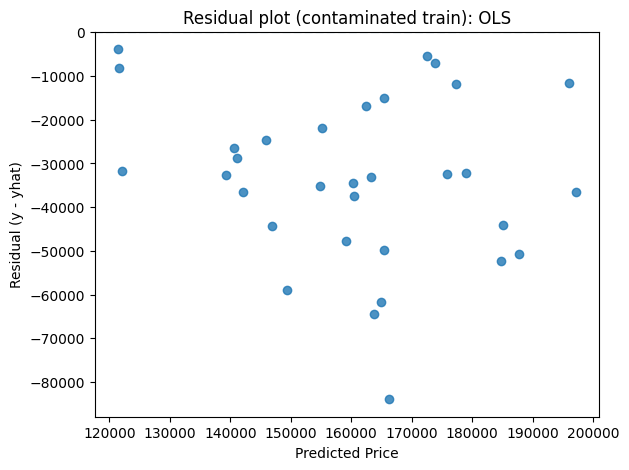

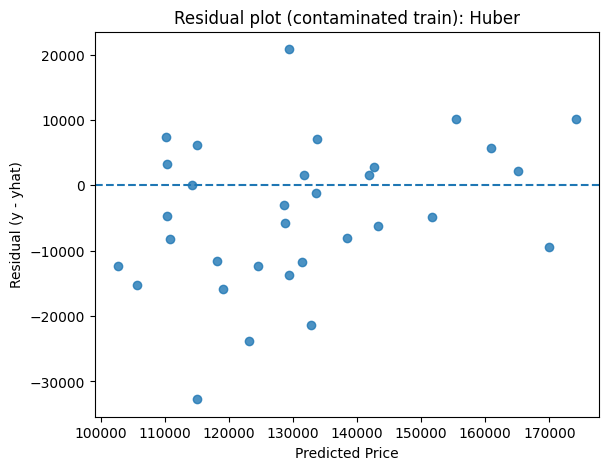

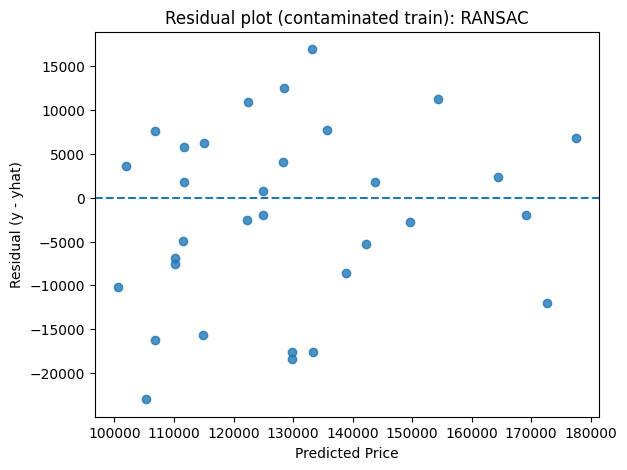

In [13]:
def residual_plot(y_true, y_pred, title):
    res = y_true - y_pred
    plt.figure(figsize=(6.5, 5))
    plt.scatter(y_pred, res, alpha=0.8)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual (y - yhat)")
    plt.title(title)
    plt.show()

for name, model in [("OLS", ols2), ("Huber", huber2), ("RANSAC", ransac2)]:
    model.fit(Xh_train_c, yh_train_c)
    pred = model.predict(Xh_test)
    residual_plot(yh_test, pred, title=f"Residual plot (contaminated train): {name}")


---
## 8. Dataset 3 (Regression): `diamonds.csv` — robust regression at larger scale

Now we use a larger, more realistic dataset:

- Path: `"../../../Datasets/Regression/diamonds.csv"`
- Target: `price`
- Mixed features including categorical variables like `cut`, `color`, `clarity`.

Diamonds pricing is a classic example where:

- Data are plentiful.
- Noise can be heteroskedastic (variance changes with carat).
- There can be mislabeled or rare items that behave like outliers.

### 8.1 Practical note: sampling

If the dataset is large, we will sample a subset for speed. The goal is not to “win a leaderboard,” but to understand robust behavior.


In [14]:
path = "../../../Datasets/Regression/diamonds.csv"
diam = pd.read_csv(path)

# Optional sampling for speed/reproducibility
diam = diam.sample(n=min(len(diam), 8000), random_state=RANDOM_STATE).reset_index(drop=True)
diam.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1389,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
1,50053,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
2,41646,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
3,42378,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
4,17245,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61


In [15]:
target = "price"
Xd = diam.drop(columns=[target])
yd = diam[target].astype(float).values

num_cols = ["carat", "depth", "table", "x", "y", "z"]
cat_cols = ["cut", "color", "clarity"]

try:
    ohe3 = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe3 = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess3 = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", ohe3)]), cat_cols),
    ],
    remainder="drop"
)

ols3 = Pipeline([("preprocess", preprocess3), ("model", LinearRegression())])
huber3 = Pipeline([("preprocess", preprocess3), ("model", HuberRegressor(epsilon=1.35, alpha=0.0002, max_iter=3000))])

try:
    ransac3_est = RANSACRegressor(
        estimator=LinearRegression(),
        min_samples=0.5,
        residual_threshold=None,
        max_trials=500,
        random_state=RANDOM_STATE,
    )
except TypeError:
    ransac3_est = RANSACRegressor(
        base_estimator=LinearRegression(),
        min_samples=0.5,
        residual_threshold=None,
        max_trials=500,
        random_state=RANDOM_STATE,
    )

ransac3 = Pipeline([("preprocess", preprocess3), ("model", ransac3_est)])

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.25, random_state=RANDOM_STATE)

# Set RANSAC threshold from a quick OLS baseline
ols3.fit(Xd_train, yd_train)
resid3 = yd_train - ols3.predict(Xd_train)
sigma3 = robust_sigma_mad(resid3)
ransac3.set_params(model__residual_threshold=2.5 * sigma3)

print("Diamonds (clean training):")
for name, model in [("OLS", ols3), ("Huber", huber3), ("RANSAC", ransac3)]:
    model.fit(Xd_train, yd_train)
    pred = model.predict(Xd_test)
    print_report(name, yd_test, pred)

Diamonds (clean training):
OLS: MAE=737.1220 | RMSE=1179.5800 | R2=0.9108
Huber: MAE=626.0038 | RMSE=1216.5599 | R2=0.9051
RANSAC: MAE=643.2970 | RMSE=1220.6616 | R2=0.9045


In [16]:
# Stress test: inject a small fraction of extreme target outliers into the training set
rng = np.random.default_rng(RANDOM_STATE)

Xd_train_c = Xd_train.copy()
yd_train_c = yd_train.copy()

n_contam = max(1, int(0.05 * len(yd_train_c)))
idx = rng.choice(len(yd_train_c), size=n_contam, replace=False)

# Add large positive spikes to price (e.g., mislabeled or rare items)
yd_train_c[idx] = yd_train_c[idx] + rng.uniform(20000, 60000, size=n_contam)

print("Injected outliers:", len(idx))

print("\nDiamonds (trained on contaminated data):")
for name, model in [("OLS", ols3), ("Huber", huber3), ("RANSAC", ransac3)]:
    model.fit(Xd_train_c, yd_train_c)
    pred = model.predict(Xd_test)
    print_report(f"{name} (contaminated train)", yd_test, pred)

Injected outliers: 300

Diamonds (trained on contaminated data):
OLS (contaminated train): MAE=2145.2191 | RMSE=2373.7455 | R2=0.6388
Huber (contaminated train): MAE=631.9506 | RMSE=1209.2891 | R2=0.9063
RANSAC (contaminated train): MAE=1062.4434 | RMSE=1642.3980 | R2=0.8271



---
## 9. Practical guidance: choosing between OLS, Huber, and RANSAC

Robust regression is not “always better.” It trades off efficiency, interpretability, and assumptions. Use the following decision framework.

### 9.1 Use OLS when

- Data quality is high and outliers are rare or already cleaned.
- The residual distribution looks approximately Gaussian with mild tails.
- You need best efficiency under the classical assumptions.
- You are mostly doing baseline modeling and want a simple reference.

### 9.2 Use Huber regression when

- You expect occasional label noise / vertical outliers.
- You want a smooth, convex objective.
- You want an estimator similar to OLS but with bounded influence.
- You plan to keep a linear model for interpretability (coefficients remain meaningful).

**Rule of thumb:** Huber is often the “first robust model to try.”

### 9.3 Use RANSAC when

- A significant fraction of points are gross outliers.
- You have bad leverage points or “wrong regime” data you want to discard.
- You can define a meaningful residual threshold separating inliers vs outliers.
- You are okay with some randomness and possible instability.

**Rule of thumb:** RANSAC is best when inliers form a dominant, coherent structure and outliers are clearly inconsistent.

### 9.4 Common pitfalls

1. **Scaling:** robust methods still need sensible feature scaling. Use pipelines.
2. **Thresholding:** RANSAC’s `residual_threshold` can make or break results.
3. **Heteroskedasticity:** if noise variance changes with $x$, a single global threshold may be inappropriate. Consider transforming $y$ (e.g., log) or using quantile regression (next lesson).
4. **Many outliers + no structure:** if there is no clear inlier model, RANSAC cannot invent one.
5. **Collinearity:** Huber with weak regularization can still be unstable in collinear settings; tune `alpha`.

### 9.5 Robustness is a workflow, not a single algorithm

In a production ML pipeline, robustness often includes:

- Data validation rules and schema checks.
- Outlier detection and triage.
- Proper train/validation splits to avoid leakage.
- Monitoring for distribution shift.
- Post-deployment retraining triggers.

Robust regression methods are one part of this larger reliability practice.



---
## 10. Deeper theory: M-estimators, heavy tails, and connection to likelihood

This section is more theoretical but helps you build durable intuition.

### 10.1 From squared loss to likelihood

Minimizing squared residuals is equivalent (under regularity conditions) to maximum likelihood estimation when errors are Gaussian:

$$
y_i = f(x_i;\beta) + \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, \sigma^2).
$$

The negative log-likelihood is proportional to $\sum r_i^2$.

### 10.2 Huber as a robust likelihood surrogate

Huber loss can be seen as combining a Gaussian-like core with Laplace-like tails. This approximates a distribution with heavier tails than Gaussian, meaning extreme deviations are *less surprising* and therefore less heavily penalized.

### 10.3 Influence functions and boundedness

An M-estimator minimizes $\sum \rho(r_i)$. Its influence function is linked to $\psi(r)=\rho'(r)$. If $\psi$ is bounded, the estimator has bounded influence (robustness). Huber has bounded $\psi$; OLS has $\psi(r)=r$ which is unbounded.

### 10.4 Robust scale: why MAD appears everywhere

The median is a robust location estimator; MAD is a robust scale estimator. Both have high breakdown points (up to 50% for median). That is why MAD is a natural tool to set thresholds for procedures like RANSAC.

### 10.5 Breakdown point (qualitative)

- OLS breakdown point is effectively $0$%: one arbitrarily bad point can ruin the fit.
- Huber improves robustness but still does not reach high breakdown because it remains a global optimization over all points.
- RANSAC can achieve a high breakdown point in practice when its inlier assumption is valid.

This is the deeper reason for the “choose the algorithm” guidance in Section 9.



---
## 11. Exercises (recommended)

### Exercise 1 — Huber tuning curve
Using the `house-prices.csv` pipeline, run a small grid over `epsilon` values, e.g. `[1.1, 1.35, 1.8, 2.5]`, and compare MAE/RMSE under **clean training** and **contaminated training**. Explain what changes as `epsilon` grows.

**Hint:** larger `epsilon` should become closer to OLS.

### Exercise 2 — MAD-based RANSAC threshold
On the `diamonds.csv` dataset, compute `sigma_hat` from an initial robust model residuals, and try thresholds `k*sigma_hat` for `k` in `[1.5, 2.0, 2.5, 3.0, 4.0]`. For each `k`, record:
- number of inliers,
- MAE/RMSE on the test set,
- qualitative stability (do results change across random seeds?)

### Exercise 3 — From-scratch Huber loss and gradient
Implement Huber loss and its derivative for a vector of residuals `r`. Plot:
- the loss curves for several `epsilon` values,
- the derivative curves (psi-functions).

Then, verify numerically (finite differences) that the derivative matches the gradient of the loss.

### Exercise 4 — Outliers in X (leverage)
Create a copy of `house-prices.csv` and inject a few extreme values in `SqFt` while keeping prices realistic. Compare how OLS, Huber, and RANSAC react. Which method is most sensitive and why?

### Exercise 5 — Robustness report template
Write a small helper that runs a “contamination benchmark”:
- choose a contamination rate `c`,
- apply a contamination rule (target spikes, feature leverage, both),
- fit models,
- report metrics.

Run it for `c` in `[0.0, 0.05, 0.10, 0.20]` and produce a plot of RMSE vs contamination rate for each model.

(Keep plot labels in English.)



---
## 12. Key takeaways

- OLS is efficient but fragile because squared loss gives unbounded influence to extreme residuals.
- Huber regression changes the loss to be quadratic near zero and linear in the tails, reducing the impact of outliers while preserving much of OLS efficiency.
- RANSAC searches for a dominant inlier structure and can tolerate severe outliers, but it depends strongly on the inlier threshold and can be unstable when assumptions fail.
- Practical robust modeling often includes MAD-based scale estimates, careful preprocessing pipelines, and explicit contamination tests.

In the next lesson (Quantile Regression and Prediction Intervals), we will extend robustness concepts toward **distributional predictions** rather than only point estimates.
